# <img src="./assets/course-icon.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

#### <a href="https://taldatech.github.io">Tal Daniel</a>

## Tutorial 09 - Transfer, Representation and Self-Supervised Learning
---

### <img src="https://img.icons8.com/bubbles/50/null/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Pre-trained Models and Transfer Learning](#-Transfer-Learning)
    * [Transfer Learning](#-Transfer-Learning-Definition)
    * [Pre-trained Models](#-Transfer-Learning-with-Pre-trained-Models)
    * [LoRA & DoRA - Low Rank Adaptation Fine-Tuning](#-LoRA-&-DoRA---Low-Rank-Adaptation-Fine-Tuning)
* [Representation Learning and Self-Supervised Learning](#-Representation-and-Self-Supervised-Learning)
    * [Autoencoders](#-Deep-Unsupervised-Learning---Deep-Autoencoders)
    * [Contrastive Methods](#--Contrastive-Learning)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision

# scikit-learn imports
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.decomposition import PCA, KernelPCA

## <img src="https://img.icons8.com/dusk/64/000000/back-sorting.png" style="height:50px;display:inline"> Transfer Learning
---
* Training deep neural networks has come a long way in past years, enabling learning good mappings from inputs to outputs, whether they are images, sentences, label predictions, etc. from large amounts of labeled data.
* However, it is usually the case that our models **struggle with generalization to unseen data during training**.
* The traditional supervised learning paradigm **breaks down** when we don't have sufficient labeled data for the task or domain we want to train our model for.
    * For example, if we want to train a model to detect pedestrians on night-time images, we could, in theory, **apply a model that has been trained on a similar domain**, e.g., on day-time images. In practice, however, we often experience a deterioration or collapse in performance as the model has inherited the **bias** of its training data and **doesn't know how to generalize** to the new domain.
* **Transfer learning** allows us to deal with such scenarios by leveraging the already existing labeled data of some related task or domain. 
    * We try to store this knowledge gained in solving the source task in the source domain and apply it to a new target task or domain. 

<center><img src='./assets/transfer_learning_setup.png' style="height:300px"></center>

* <a href="https://ruder.io/transfer-learning/">Image Source</a>

## <img src="https://img.icons8.com/nolan/64/math.png" style="height:50px;display:inline"> Transfer Learning Definition
---
* Transfer learning involves the concepts of a **domain** and a **task**.
* For simplicity, we assume a binary classification setting.
* We denote the following: a domain $\mathcal{D}$ consists of a feature space $\mathcal{X}$ and a marginal probability distribution $P(X)$ over the feature space, where $X=x_1, x_2, ...,x_n \in \mathcal{X}.$
* Given a domain, $\mathcal{D}= \{\mathcal{X}, P(X) \}$, a task $\mathcal{T}$ consists of a label space $\mathcal{Y}$ and a conditional probability distribution $P(Y|X)$ that is typically learned from the training data consisting of pairs $x_i \in \mathcal{X}$ and $y_i \in \mathcal{Y}$.
    * In the binary classification case, $y_i \in \{True, False\}$.
* Given a source domain $\mathcal{D}_S$, a corresponding source task $\mathcal{T}_S$, as well as a target domain $\mathcal{D}_T$ and a target task $\mathcal{T}_T$, the objective of transfer learning is to enable us to learn the **target conditional probability** distribution $P(Y_T|X_T)$ in $\mathcal{D}_T$ with the information gained from $\mathcal{D}_S$ and $\mathcal{T}_S$.
    * We assume $\mathcal{D}_S \neq \mathcal{D}_T$ ("domain adaptation") or $\mathcal{T}_S \neq \mathcal{T}_T$ ("transfer learning").
* In most cases, a limited number of labeled target examples, which is exponentially smaller than the number of labeled source examples are assumed to be available.


## <img src="https://img.icons8.com/nolan/64/movie.png" style="height:50px;display:inline"> Transfer Learning Scenarios
---
1. $\mathcal{X}_S \neq \mathcal{X}_T$ - the feature spaces of the source and target domain are different.
    * Example: cross-lingual adaptation - in a document classification task, the documents are written in two different languages. 
2. $P(X_S) \neq P(X_T)$ - the marginal probability distributions of source and target domain are different.
    * Example: domain adaptation -  in a document classification task, the documents ($X$) discuss different topics.
3. $\mathcal{Y}_S \neq \mathcal{Y}_T$ - the label spaces between the two tasks are different.
    * Example: documents need to be assigned different labels in the target task.
    * Usually happens with scenario 4 (as it is rare for two different tasks to have different label spaces, but exactly the same conditional probability distributions).
4. $P(Y_S|X_S) \neq P(Y_T|X_T)$ - the conditional probability distributions of the source and target tasks are different. Very common in practice.
    * Example: source and target documents are unbalanced with regard to their classes. 

## <img src="https://img.icons8.com/bubbles/50/000000/car.png" style="height:50px;display:inline"> Transfer Learning Applications
---
* **Sim2Real** - transferring from simulation to real environments. For many machine learning applications that rely on hardware for interaction, gathering data and training a model in the real world is either **expensive, time-consuming, or simply too dangerous**. It is thus advisable to gather data in some other, less risky way.
    * Learning from a simulation and applying the acquired knowledge to the real world is an instance of transfer learning **scenario 2**, as the feature spaces between source and target domain are the same (both generally rely on pixels), but the **marginal probability distributions between simulation and reality are different**, i.e. objects in the simulation and the source look different, although this difference diminishes as simulations get more realistic. 
    * At the same time, **the conditional probability distributions** between simulation and real world might be different as the simulation is not able to fully replicate all reactions in the real world, e.g. a physics engine can not completely mimic the complex interactions of real-world objects.
    * Common applications include autonomus driving and robotics (where gathering data can be slow or dangerous).

<center><img src='./assets/robot_and_simulation.png' style='height:200px'></center>

* <a href="https://arxiv.org/abs/1610.04286">Image Source</a>

* **Domain Adaptation** - transferring between domains that share some properties. 
    * In **vision**, we commonly have many labeled data for some domain, but for the actual data that we care about, there are very few labels or none at all. Even if the training and the test data look the same, **the training data may still contain a bias that is imperceptible to humans but the model can still exploit it to overfit the training data**.
    * In **NLP**, models trained on news data have difficulty coping with more novel text forms such as social media messages and the challenges they present. Even within one domain such as product reviews, people employ different words and phrases to express the same opinion. A model trained on one type of review should thus be able to disentangle the general and domain-specific opinion words that people use in order not to be confused by the shift in domain.

## <img src="https://img.icons8.com/nolan/64/system-task.png" style="height:50px;display:inline"> Transfer Learning with Pre-trained Models
---
* One of the fundamental requirements for transfer learning is the presence of models that perform well on source tasks.
* The two most common fields that build upon pre-trained models to transfer between tasks and domains are computer vision and NLP.

### <img src="https://img.icons8.com/fluent/96/000000/image.png" style="height:50px;display:inline"> Using Pre-trained CNN Features
---
* Evidently, lower convolutional layers capture **low-level image features**, e.g., edges , while higher convolutional layers capture more complex details, such as body parts, faces, and other compositional features.
* The **final fully-connected layers** are generally assumed to capture information that is relevant for solving the respective task, e.g., classification.
* Representations that capture general information of how an image is composed and what combinations of edges and shapes it contains **can be helpful in other tasks**. This information is contained in one of the final convolutional layers or early fully-connected layers in large convolutional neural networks trained on ImageNet.
* For a new task, we can thus simply use the off-the-shelf features of a state-of-the-art CNN pre-trained on ImageNet and train a new model on these extracted features. 
* In practice, we either **keep the pre-trained parameters fixed or tune them with a small learning rate** in order to ensure that we do not "forget" the previously acquired knowledge.

<center><img src='./assets/transfer_learning_vgg.jpeg' style="height:300px"></center>

* <a href="https://medium.com/datadriveninvestor/what-you-must-know-about-transfer-learning-4a6e4cb9fbad">Image Source</a>

### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Transfer Learning Example with PyTorch
---
* We will follow examples by <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html">Sasank Chilamkurthy</a> and <a href="https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html">Nathan Inkawhich</a>.
* We will train a classifier to distinguish between **ants** and **bees**.
    * The data can be downloaded from here: <a href="https://download.pytorch.org/tutorial/hymenoptera_data.zip">Download Link</a>.
* There are two major transfer learning scenarios:
    * **Fine-tuning the ConvNet**: Instead of random initializaion, we initialize the network with a pretrained network, like VGG for example (which is trained on ImageNet 1000 dataset). Rest of the training looks as usual (except for usually using a lower learning rate).
    * **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained. The advantage is very quick training, but several parts of the model are not adapted to the new objective.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 4
data_dir = './datasets/hymenoptera_data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5, 8))
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_axis_off()

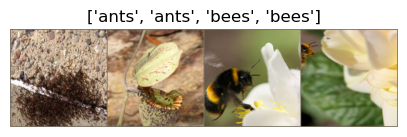

In [4]:
# Let’s visualize a few training images so as to understand the data augmentations.
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Set Model Parameters’ `.requires_grad` attribute
---
* The following helper function sets the `.requires_grad` attribute of the parameters in the model to `False` when we are feature extracting. 
* By default, when we load a pretrained model all of the parameters have `.requires_grad=True`, which is fine if we are training from scratch or fine-tuning.
* However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients.

In [5]:
def set_parameter_requires_grad(model, feature_extracting=False):
    # approach 1
    if feature_extracting:
        # frozen model
        model.requires_grad_(False)
    else:
        # fine-tuning
        model.requires_grad_(True)
        
    # approach 2
    if feature_extracting:
        # frozen model
        for param in model.parameters():
            param.requires_grad = False
    else:
        # fine-tuning
        for param in model.parameters():
            param.requires_grad = True
    # note: you can also mix between frozen layers and trainable layers, but you'll need a custom 
    # function that loops over the model's layers and you specify which layers are frozen.

#### Initialize and Reshape the Networks
---
* Recall, the final layer of a CNN model, which is often an FC layer, has the same number of nodes as the number of output classes in the dataset. 
* Since all of the following models have been pretrained on ImageNet, they all have output layers of size 1000, one node for each class. 
* The goal here is to **reshape the last layer to have the same number of inputs as before**, AND to have the **same number of outputs as the number of classes in the dataset**. 

* When *feature extracting*, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. 
* Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the `.requires_grad` attribute to `False`. 
* This is important because by default, this attribute is set to `True`. Then, when we initialize the new layer and by default the new parameters have `.requires_grad=True` so only the new layer’s parameters will be updated. 
* When we are fine-tuning we can leave all of the `.required_grad`’s set to the default of `True`.

### <img src="https://img.icons8.com/nolan/64/download-from-cloud.png" style="height:50px;display:inline"> Torchvision Pre-Trained Models
---
* The `torchvision.models` subpackage contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection, video classification, and optical flow.
* You can see all the available here - <a href="https://pytorch.org/vision/stable/models.html">Models and pre-trained weights</a>.
    * In code, you can use <a href="https://pytorch.org/vision/stable/models.html#listing-and-retrieving-available-models">`torchvision.models.list_models`</a> to see a list of all available models.
* Examples:

In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0  # image size, e.g. (3, 224, 224)
    # new method from torchvision >= 0.13
    weigths = 'DEFAULT' if use_pretrained else None 
    # to use other checkpoints than the default ones, check the model's available chekpoints here:
    # https://pytorch.org/vision/stable/models.html
    if model_name == "resnet":
        """ Resnet18
        """
        # new method from torchvision >= 0.13
        model_ft = models.resnet18(weights=weights)
        # old method for toechvision < 0.13
        # model_ft = models.resnet18(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # replace the last FC layer
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        # new method from torchvision >= 0.13
        model_ft = models.alexnet(weights=weights)
        # old method for toechvision < 0.13
        # model_ft = models.alexnet(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        # new method from torchvision >= 0.13
        model_ft = models.vgg16(weights=weights)
        # old method for toechvision < 0.13
        # model_ft = models.vgg16(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        # new method from torchvision >= 0.13
        model_ft = models.squeezenet1_0(weights=weights)
        # old method for toechvision < 0.13
        # model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        # new method from torchvision >= 0.13
        model_ft = models.densenet121(weights=weights)
        # old method for toechvision < 0.13
        # model_ft = models.densenet121(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise NotImplementedError

    return model_ft, input_size

In [21]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we fine-tune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [22]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  fine-tuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []  # override the initial list definition above
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [7]:
"""
Training function
"""
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [29]:
# Setup the loss fn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.2460 Acc: 0.9057
val Loss: 0.1525 Acc: 0.9542

Epoch 1/14
----------
train Loss: 0.2114 Acc: 0.9139
val Loss: 0.1093 Acc: 0.9477

Epoch 2/14
----------
train Loss: 0.1623 Acc: 0.9221
val Loss: 0.1752 Acc: 0.9412

Epoch 3/14
----------
train Loss: 0.2186 Acc: 0.9262
val Loss: 0.1530 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.1423 Acc: 0.9467
val Loss: 0.1667 Acc: 0.9412

Epoch 5/14
----------
train Loss: 0.1301 Acc: 0.9508
val Loss: 0.1108 Acc: 0.9673

Epoch 6/14
----------
train Loss: 0.1602 Acc: 0.9303
val Loss: 0.1001 Acc: 0.9412

Epoch 7/14
----------
train Loss: 0.1888 Acc: 0.9385
val Loss: 0.1254 Acc: 0.9542

Epoch 8/14
----------
train Loss: 0.1432 Acc: 0.9508
val Loss: 0.1194 Acc: 0.9608

Epoch 9/14
----------
train Loss: 0.1139 Acc: 0.9631
val Loss: 0.1230 Acc: 0.9608

Epoch 10/14
----------
train Loss: 0.2273 Acc: 0.9467
val Loss: 0.1154 Acc: 0.9608

Epoch 11/14
----------
train Loss: 0.1507 Acc: 0.9385
val Loss: 0.1096 Acc: 0.9608

Ep

## <img src="https://img.icons8.com/pulsar-color/96/split.png" style="height:50px;display:inline"> LoRA & DoRA - Low Rank Adaptation Fine-Tuning

---
Based on the great blog post "<a href="https://magazine.sebastianraschka.com/p/lora-and-dora-from-scratch">Improving LoRA: Implementing Weight-Decomposed Low-Rank Adaptation (DoRA) from Scratch" by Sebastian Raschka</a>.

* Low-rank adaptation (LoRA) is a technique to fine-tune a pre-trained model by adjusting only a small, low-rank subset of the model's parameters.
* It allows for efficient fine-tuning of large models on task-specific data, significantly reducing the computational cost and time required for fine-tuning.

### LoRA: Low Rank Adaptation
---
* Introduced in <a href="https://arxiv.org/abs/2106.09685">"LoRA: Low-Rank Adaptation of Large Language Models"</a> by Hu et al.
* Given a weight matrix $W \in \mathbb{R}^{d_i \times d_o}$, in regular training or fine-tuning using gradient descent, the weights are updated according to: $$ W_{\text{updated}} = W + \Delta W. $$
* LoRA proposes an alternative method for this update, by learning a low-rank approximation of $\Delta W$: $$ \Delta W \approx AB, $$ where $A \in \mathbb{R}^{d_i \times r}$, $B \in \mathbb{R}^{r \times d_i}$ and $r << d_i, d_o$ is the *rank* (very similar to SVD--Singular Value Decomposition).
* In practice, we usually keep $W$ frozen and only learn $A$ and $B$.
* LoRA can potenially save a lot of memory; for example, if $d_i = d_o = 1000$, then a full fine-tuning requires training $1000 \times 1000 = 1,000,000$ parameters. However, if we consider $r=2$ then $A$ and $B$ have $1000 \times 2$ parameters each, resulting in only $4,000$ parameters ($250$ fewer parameters!).
* <a href="https://github.com/microsoft/LoRA">PyTorch Code</a>

<center><img src='./assets/lora.jpeg' style="height:300px"></center>

### DoRA: Weight-Decomposed Low Rank Adaptation
---
* Introduced in <a href="https://arxiv.org/abs/2402.09353">DoRA: Weight-Decomposed Low-Rank Adaptation"</a> by Liu et al.
* DoRA build upon LoRA and extends it by considering the principle that any vector can be represented as the product of its **magnitude** (a scalar value indicating its length) and its **direction** (a unit vector indicating its orientation in space).
* The paper found that LoRA either increases or decreases magnitude and direction updates proportionally but seems to lack the capability to make only subtle directional changes as found in full fine-tuning. Hence, they propose the decoupling of magnitude and directional components.
* In DoRA, we apply the decomposition into magnitude and directional components to a whole pretrained weight matrix $W$ instead of a vector, where each column (vector) of the weight matrix corresponds to the weights connecting all inputs to a particular output neuron.
* In practice, DoRA takes the directional matrix $V=\frac{W + AB}{|| W+AB||}$ and applies standard LoRA, for instance: $$ W_{\text{updated}} = m \cdot \frac{W + AB}{|| W+AB||}. $$
* <a href="https://github.com/catid/dora">PyTorch Code</a>

<center><img src='./assets/dora.png' style="height:500px"></center>

<center><img src='./assets/lora_vs_dora.png' style="height:200px"></center>
<center><img src='./assets/lora_vs_dora_2.png' style="height:250px"></center>

#### <img src="https://img.icons8.com/cotton/64/000000/olympic-torch.png" style="height:50px;display:inline"> Low-Rank Adaptation in PyTorch
---

In [11]:
# example
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation, 
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted. 
        
        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))
        
        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T 
            return F.linear(x, combined_weight, self.linear.bias)

In [15]:
# let's fine-tune vgg's penultimate fc layer
weigths = 'DEFAULT'
model_ft = models.vgg16(weights=weigths)
# turn off gradients
model_ft.requires_grad_(False)
# replace the penultimate fc layer (a 4096 x 4096 weight matrix) with low-rank adaptation
rank = 4
alpha = 8
model_ft.classifier[3] =  LowRankLayer(model_ft.classifier[3], rank, alpha, use_dora=True)
# change the last linear layer to the correct number of classes
num_classes = 2
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
input_size = 224

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# print and collect learnable paramters
print("Params to learn:")
params_to_update = []  # override the initial list definition above
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.3.A
	 classifier.3.B
	 classifier.3.m
	 classifier.6.weight
	 classifier.6.bias


In [17]:
# hyper-parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 8
num_epochs = 15
model_ft = model_ft.to(device)
# optimizer
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.0002)
# loss function
criterion = nn.CrossEntropyLoss()
# train
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.4624 Acc: 0.7541
val Loss: 0.2203 Acc: 0.9477

Epoch 1/14
----------
train Loss: 0.2490 Acc: 0.9139
val Loss: 0.1516 Acc: 0.9542

Epoch 2/14
----------
train Loss: 0.2523 Acc: 0.9098
val Loss: 0.1460 Acc: 0.9804

Epoch 3/14
----------
train Loss: 0.1845 Acc: 0.9344
val Loss: 0.1168 Acc: 0.9739

Epoch 4/14
----------
train Loss: 0.1578 Acc: 0.9508
val Loss: 0.1487 Acc: 0.9542

Epoch 5/14
----------
train Loss: 0.1988 Acc: 0.9426
val Loss: 0.1284 Acc: 0.9673

Epoch 6/14
----------
train Loss: 0.2539 Acc: 0.8934
val Loss: 0.1873 Acc: 0.9477

Epoch 7/14
----------
train Loss: 0.2276 Acc: 0.8934
val Loss: 0.1416 Acc: 0.9542

Epoch 8/14
----------
train Loss: 0.2035 Acc: 0.9221
val Loss: 0.1160 Acc: 0.9608

Epoch 9/14
----------
train Loss: 0.2706 Acc: 0.9016
val Loss: 0.1437 Acc: 0.9412

Epoch 10/14
----------
train Loss: 0.1976 Acc: 0.9262
val Loss: 0.1392 Acc: 0.9673

Epoch 11/14
----------
train Loss: 0.1820 Acc: 0.9303
val Loss: 0.1148 Acc: 0.9608

Ep

### <img src="https://img.icons8.com/cute-clipart/64/000000/language.png" style="height:50px;display:inline"> Pre-training for Natural Language Processing
---
* One of the greatest challenges in NLP is the shortage of labeled training data.
* Because NLP is a diversified field with many distinct tasks, most task-specific datasets contain only a few thousand or a few hundred thousand human-labeled training examples. 
* As big companies like Google and OpenAI have shown, **modern deep learning-based NLP models see benefits from much larger amounts of data, improving when trained on millions, or billions, of annotated training examples**.
* Large pre-trained models on the enormous amount of **unannotated text on the web** can then be fine-tuned on small-data NLP tasks like question answering and sentiment analysis, resulting in substantial accuracy improvements compared to training on these datasets from scratch.
* **Bidirectional Encoder Representations from Transformers (BERT), Google** - a Transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. The idea is to mask certain words and then try to predict them. The original English-language BERT model comes with two pre-trained general types:
    * (1) the $BERT_{BASE}$ model, a 12-layer, 768-hidden, 12-heads, 110M parameter neural network architecture.
    * (2) the $BERT_{LARGE}$ model, a 24-layer, 1024-hidden, 16-heads, 340M parameter neural network architecture. 
    * Both of which were trained on the BooksCorpus dataset with 800M words, and a version of the English Wikipedia with 2,500M words.
* BERT uses the straightforward technique of masking out some of the words in the input and then condition each word bidirectionally to predict the masked words and also learns to model relationships between sentences by pre-training on a very simple task that can be generated from any text corpus: Given two sentences A and B, is B the actual next sentence that comes after A in the corpus, or just a random sentence? 

<center><img src="./assets/bert_1.png" style="height:50px"></center>

<center><img src="./assets/bert_ill_1.png" style="height:350px"></center>

* <a href="https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html">Image Source 1</a>, <a href="http://jalammar.github.io/illustrated-bert/">Image Source 2</a>

<center><img src="./assets/bert_2.png" style="height:100px"></center>
<center><img src="./assets/bert_ill_2.png" style="height:350px"></center>

* <a href="https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html">Image Source 1</a>, <a href="http://jalammar.github.io/illustrated-bert/">Image Source 2</a>

#### Pre-trained Models for NLP in PyTorch
---
* <a href="https://huggingface.co/">HuggingFace</a> is a copmpany that is dedicated to publishing all of the available pretrained models and it works with PyTorch as well - <a href="https://github.com/huggingface/transformers">HuggingFace Transformers</a>
* <a href="https://pytorch.org/hub/huggingface_pytorch-transformers/">Examples with PyTorch</a>
* <a href="https://huggingface.co/docs/transformers/training">Tutorial: Fine-tune Transformers for NLP Tasks with PyTorch and HuggingFace</a>.

<center><img src="./assets/huggingface.PNG" style="height:500px"></center>

## <img src="https://img.icons8.com/color/96/000000/self-esteem.png" style="height:50px;display:inline"> Representation and Self-Supervised Learning
---
* How do we learn rich and useful features from raw unlabeled data that can be useful for several downstream tasks (e.g., classification, reinforcement learning...)?
* What are the various general tasks that can be used to learn representations from unlabeled data?
* **The way we represent the data has a great impact on the performance and compelxity**.
* Such representations can be learned in typical *unsupervised* settings, or in a *self-supervised* manner.

<center><img src="./assets/rep_data.PNG" style="height:250px"></center>

* **Deep Unsupervised Learning** - learn representations without lables, subset of deep learning, which is a subset of representation learning, which is a subset of machine learning.
* **Self-supervised Learning** - often used interchangeably with unsupervised learning. Self-supervised: **create your own supervision through pretext tasks**.

### <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> Deep Unsupervised Learning - Deep Autoencoders
---
* Most of the natural data is high-dimensional, such as images. Consider the MNIST (hand-written digits) dataset, where each image has $28x28=784$ pixels, which means it can be represented by a vector of length 784. 
    * But do we really need 784 values to represent a digit? The answer is probably no. We believe that the data lies on a low-dimensional space which is enough to describe the observasions. In the case of MNIST, we can choose to represent digits as one-hot vectors, which means we only need 10 dimensions. So we can **encode** high-dimensional observations in a low-dimensional space.
    * But how can we learn meaningful low-deminsional representations? The general idea is to reconstruct or, **decode** the low-dimensional representation to the high-dimensional reperesentation, and use the reconstruction error to find the best representations (using the gradients of the error) . This is the core idea behind **autoencoders**.
    * **Autoencoders** - models which take data as input and discover some latent state representation of that data.The input data is converted into an encoding vector where each dimension represents some learned attribute about the data. The most important detail to grasp here is that our encoder network is outputting a single value for each encoding dimension. The decoder network then subsequently takes these values and attempts to recreate the original input. Autoencoders have **three parts**: an encoder, a decoder, and a 'loss' function that maps one to the other. For the simplest autoencoders - the sort that compress and then reconstruct the original inputs from the compressed representation - we can think of the 'loss' as describing the amount of information lost in the process of reconstruction.
        * Illustration: <center><img src="./assets/tut_xv_autoencoder.png" style="height:250px"></center>
        
* The basic architecture of an autoencoder:
<center><img src="./assets/tut_xiv_autoencoder.png" style="height:250px"></center>
    
    * Image from <a href="https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798">Applied Deep Learning</a> by Arden Dertat
    
Let's implement it in PyTorch using what we have learnt so far!

In [14]:
class AutoEncoder(nn.Module):
    
    def __init__(self, input_dim=28*28, hidden_dim=256, latent_dim=10):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # define the encoder
        self.encoder = nn.Sequential(nn.Linear(self.input_dim, self.hidden_dim),
                                     nn.ReLU(), nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.latent_dim)
                                    )
        
        # define decoder
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.input_dim),
                                     nn.Sigmoid())
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_latent_rep(self, x):
        return self.encoder(x)

In [15]:
# hyper-parameters:
num_epochs = 5
learning_rate = 0.001

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create model, send it to device
model = AutoEncoder(input_dim=28*28, hidden_dim=128, latent_dim=10).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # binary cross entropy, as pixels are in [0,1], can also use MSE
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# Train the model
total_step = len(fmnist_train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(fmnist_train_loader):
        # each i is a batch of 128 samples
        images = images.to(device).view(batch_size, -1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward and optimize - ALWAYS IN THIS ORDER!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/5], Step [100/468], Loss: 0.3832
Epoch [1/5], Step [200/468], Loss: 0.3317
Epoch [1/5], Step [300/468], Loss: 0.3360
Epoch [1/5], Step [400/468], Loss: 0.3037
Epoch [2/5], Step [100/468], Loss: 0.3093
Epoch [2/5], Step [200/468], Loss: 0.2943
Epoch [2/5], Step [300/468], Loss: 0.3223
Epoch [2/5], Step [400/468], Loss: 0.3077
Epoch [3/5], Step [100/468], Loss: 0.2953
Epoch [3/5], Step [200/468], Loss: 0.3018
Epoch [3/5], Step [300/468], Loss: 0.3083
Epoch [3/5], Step [400/468], Loss: 0.3133
Epoch [4/5], Step [100/468], Loss: 0.3082
Epoch [4/5], Step [200/468], Loss: 0.3007
Epoch [4/5], Step [300/468], Loss: 0.2898
Epoch [4/5], Step [400/468], Loss: 0.2976
Epoch [5/5], Step [100/468], Loss: 0.3038
Epoch [5/5], Step [200/468], Loss: 0.2896
Epoch [5/5], Step [300/468], Loss: 0.2972
Epoch [5/5], Step [400/468], Loss: 0.2990


shape: 
 torch.Size([128, 1, 28, 28])


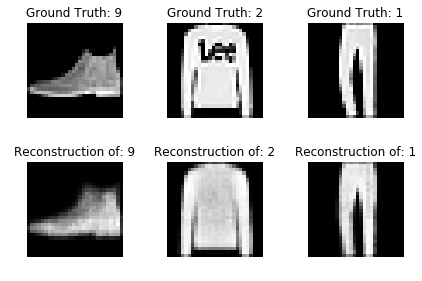

In [17]:
# let's see some of the reconstructions
model.eval()  # put in evaluation mode - no gradients
examples = enumerate(fmnist_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("shape: \n", example_data.shape)
fig = plt.figure()
for i in range(3):
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(example_data[i][0], cmap='gray', interpolation='none')
    ax.set_title("Ground Truth: {}".format(example_targets[i]))
    ax.set_axis_off()
    
    ax = fig.add_subplot(2,3,i+4)
    recon_img = model(example_data[i][0].view(1, -1).to(device)).data.cpu().numpy().reshape(28, 28)
    ax.imshow(recon_img, cmap='gray')
    ax.set_title("Reconstruction of: {}".format(example_targets[i]))
    ax.set_axis_off()
plt.tight_layout()

In [18]:
# let's compare different dimensionality reduction methods
n_neighbors = 10
n_components = 2
n_points= 500

fmnist_test_loader = torch.utils.data.DataLoader(dataset=fmnist_test_dataset,
                                          batch_size=n_points, 
                                          shuffle=False)
X, labels = next(iter(fmnist_test_loader))
latent_X = model.get_latent_rep(X.to(device).view(n_points, -1)).data.cpu().numpy()
labels = labels.data.cpu().numpy()

PCA time: 0.001 sec
KPCA time: 0.013 sec
LLE time: 0.077 sec
Isomap time: 0.12 sec
t-SNE time: 2.7 sec


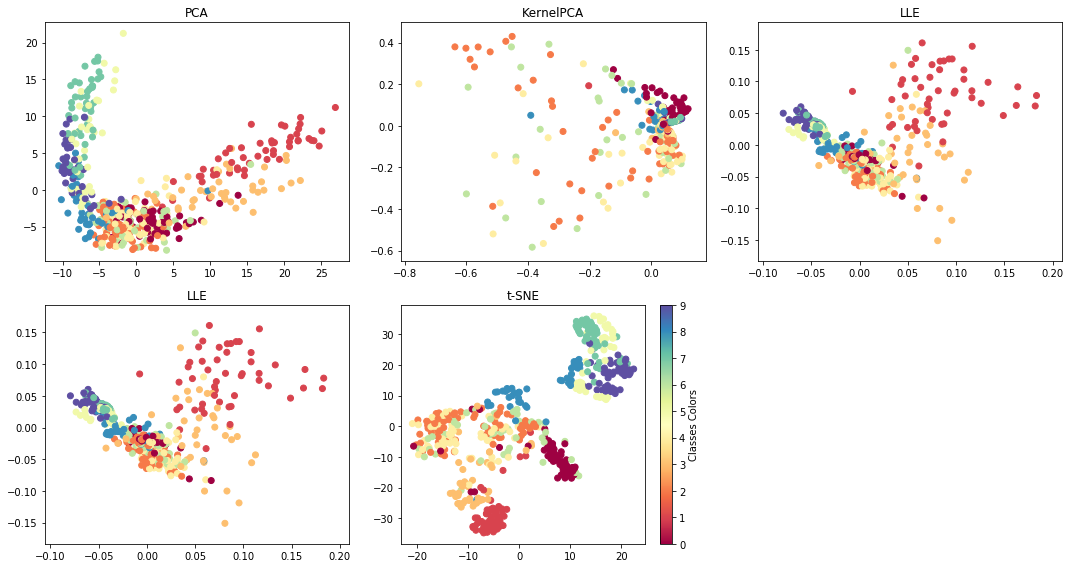

In [19]:
fig = plt.figure(figsize=(15,8))

# PCA
t0 = time.time()
x_pca = PCA(n_components).fit_transform(latent_X)
t1 = time.time()
print("PCA time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 1)
ax.scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('PCA')

# KPCA
t0 = time.time()
x_kpca = KernelPCA(n_components, kernel='rbf').fit_transform(latent_X)
t1 = time.time()
print("KPCA time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 2)
ax.scatter(x_kpca[:, 0], x_kpca[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('KernelPCA')

# LLE
t0 = time.time()
x_lle = LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto').fit_transform(latent_X)
t1 = time.time()
print("LLE time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 3)
ax.scatter(x_lle[:, 0], x_lle[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('LLE')

# Isomap
t0 = time.time()
x_isomap = Isomap(n_neighbors, n_components).fit_transform(latent_X)
t1 = time.time()
print("Isomap time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 4)
ax.scatter(x_lle[:, 0], x_lle[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('LLE')

# t-SNE
t0 = time.time()
x_tsne = TSNE(n_components).fit_transform(latent_X)
t1 = time.time()
print("t-SNE time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 5)
scatter = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('t-SNE')

bounds = np.linspace(0, 10, 11)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds)
cb.set_label('Classes Colors')

plt.tight_layout()

### <img src="https://img.icons8.com/cute-clipart/64/000000/task.png" style="height:50px;display:inline"> Self-Supervised Learning
---
* A version of unsupervised learning where **data provides the supervision**.
* **Idea**: withhold some part of the data and then task a neural network to predict it from the remaining parts.
* Details decide what proxy loss or pretext task the network tries to solve, and depending on the quality of the task, good semantic features can be obtained without actual labels.
* Advantages over supervised learning:
    * Large cost of producing a new dataset for each task (prepare labeling manuals, categories, hiring humans, creating GUIs, storage pipelines, etc).
    * Good supervision may not be cheap (e.g., medicine, legal).
    * Take advantage of vast amount of unlabeled data on the internet (images, videos, language).

<center><img src="./assets/ss_learning.PNG" style="height:300px"></center>

### <img src="https://img.icons8.com/cute-clipart/64/000000/console.png" style="height:50px;display:inline"> Self-Supervised Learning Methods
---
* *Reconstruct from a corrupted (or partial) version*
    * Denoising Autoencoders, Masked Autoencoders
    * In-painting
    * Colorization, Split-Brain Autoencoder
* *Visual common sense tasks*
    * Relative patch prediction
    * Jigsaw puzzles
    * Rotation prediction
* **Contrastive Learning**
    * word2vec
    * Contrastive Predictive Coding (CPC)
    * Instance Discrimination
    *  Simple Framework for Contrastive Learning of Visual Representations (SimCLR), Momentum Contrast (MoCo), Bootstrap Your Own Latent (BYOL)
    

**Code Demos** - <a href="https://colab.research.google.com/github/taldatech/ee046211-deep-learning/blob/main/extra/Self_Supervised_Learning_Demos.ipynb">Self-Supervised Learning Demos</a>

### <img src="https://img.icons8.com/external-wanicon-lineal-color-wanicon/64/null/external-mask-brazilian-carnival-wanicon-lineal-color-wanicon.png" style="height:50px;display:inline">  Masked Autoencoders (Vision Transformers)
---
* While the field of self-supervised has been taken away by storm with the introduction of contrastive methods, the recent developments in Vision Transformers (ViT) have resurrected the simple idea of masked image modeling.
* <a href="https://arxiv.org/abs/2111.06377">Masked Autoencoders Are Scalable Vision Learners, He et al. 2021.</a>
* **Masked Autoencoders**: During pre-training, **a large random subset of image patches** (e.g., 75%) is masked out. The encoder is applied to the small subset of visible patches. Mask tokens are introduced after the encoder, and the full set of encoded patches and mask tokens is processed by a small decoder that reconstructs the original image in pixels. After pre-training, the decoder is discarded and the encoder is applied to uncorrupted images (full sets of patches) for recognition tasks.
* Masked AEs show competative performance to contrastive methods while being much simpler to implement and understand.
* Code:
    * HuggingFace: <a href="https://huggingface.co/docs/transformers/model_doc/vit_mae">ViTMAE</a>
    * GitHub: <a href="https://github.com/facebookresearch/mae">Official PyTorch implementation (FAIR)</a>, <a href="https://github.com/EdisonLeeeee/Awesome-Masked-Autoencoders">Awesome MAE Models</a>

<center><img src="./assets/masked_ae.PNG" style="height:300px"></center>

<center><img src="./assets/masked_ae_sample.PNG" style="height:220px"></center>

<center><img src="./assets/masked_ae_table.PNG" style="height:150px"></center>

### <img src="https://img.icons8.com/plasticine/100/000000/protect-from-magnetic-field.png" style="height:50px;display:inline">  Contrastive Learning
---
* Contrastive learning is an approach to formulate the task of **finding similar and dissimilar things for a ML model (basically what classification does when given labels)**. 
* Contrastive methods, as the name implies, learn representations by contrasting **positive and negative** examples. 
* Using this approach, one can train a machine learning model to classify between similar and dissimilar images.
* More formally, for any data point $x$, contrastive methods aim to learn an encoder $f$ such that: 
    * $x^+$ is a data point similar to $x$, referred to as a *positive* sample.
    * $x^−$ is a data point dissimilar to $x$, referred to as a *negative* sample.
    * The **score function** is a metric that measures the similarity between two features: $$score(f(x), f(x^+))  >>  score(f(x), f(x^-))$$

<center><img src="./assets/contrastive_1.PNG" style="height:150px"></center>
<center><img src="./assets/contrastive_puzzle.gif" style="height:200px"></center>

* <a href="https://analyticsindiamag.com/contrastive-learning-self-supervised-ml">Image Source</a>

* The most common loss function to implement the score paradigm is **InfoNCE** loss, which looks similar to softmax.

<center><img src="./assets/infonce_loss.png" style="height:100px"></center>

* The denominator terms consist of one positive sample, and $N−1$ negative samples.
    * But how do we get negative samples if we are in a self-supervised setting? The answer might not suprise you -- usually the negative samples are just all other samples in the batch.
* <a href="https://github.com/RElbers/info-nce-pytorch">InfoNCE Loss in PyTorch</a>

### <img src="https://img.icons8.com/pastel-glyph/64/000000/qr-code--v2.png" style="height:50px;display:inline">  Contrastive Predictive Coding (CPC)
---
* <a href="https://arxiv.org/abs/1807.03748">**Contrastive Predictive Coding (CPC)**</a> learns self-supervised representations by **predicting the future** in a learned *latent space* by using powerful autoregressive models. 
* The model uses a probabilistic contrastive loss which induces the latent space to capture information that is **maximally useful to predict future samples**.

<center><img src="./assets/cpc.png" style="height:300px"></center>

* First, a non-linear encoder $g_{enc}$ maps the input sequence of observations $x_t$ to a sequence of latent representations $z_t = g_{enc}(x_t)$, potentially with a lower temporal resolution ($g_{enc}$'s architecture usually depends on the data type, e.g., CNN for images).
* Next, an autoregressive model $g_{ar}$ summarizes all $z \leq t$ in the latent space and produces a context latent representation $c_t=g_{ar}(z \leq t)$.
* A density ratio $f$ is modeled which preserves the **mutual information** between $x_{t+k}$ and $c_t$ as follows: $$ f_k(x_{t+k}, c_t) = \exp(z_{t+k}^T W_k c_t) \propto \frac{p(x_{t+k} | c_t)}{p(x_{t+k})} $$
    * Note that the density ratio $f$ can be unnormalized (does not have to integrate to 1).
    * $W_k$ are learned weights.
* Any type of encoder and autoregressive can be used. 
    * For example: strided convolutional layers with residual blocks and GRUs.
* The encoder and autoregressive models are trained to minimize an **InfoNCE** loss.
* <a href="https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch">PyTorch Code</a>

### <img src="https://img.icons8.com/nolan/64/collapse-arrow.png" style="height:50px;display:inline">  Simple Framework for Contrastive Learning of Visual Representations (SimCLR)
---
* <a href="https://arxiv.org/abs/2002.05709">**Simple Framework for Contrastive Learning of Visual Representations (SimCLR)**</a> is a framework for contrastive learning of *visual* representations. 
* It learns representations by maximizing agreement between differently augmented views of the same data example via a contrastive loss in the latent space.

<center><img src="./assets/simclr.PNG" style="height:300px"></center>

* A **stochastic data augmentation module** that transforms any given data example randomly resulting in two correlated views of the same example, denoted $\tilde{x}_i$ and $\tilde{x}_j$, which is considered a **positive pair**.
* SimCLR sequentially applies three simple augmentations: random cropping followed by resize back to the original size, random color distortions, and random Gaussian blur. The authors find **random crop and color distortion** are crucial to achieve good performance.
* A neural network base encoder $f(\cdot)$ that extracts **representation vectors** from augmented data examples. The framework allows various choices of the network architecture without any constraints. 
    * For simplicity ResNet is used to obtain $h_i = f(\tilde{x}_i)\in \mathbb{R}^d$ where $h_i$ is the output after the average pooling layer.
* A small neural network projection head $g(\cdot)$ that maps representations to the space where contrastive loss is applied. 
* MLP with one hidden layer is used to obtain $z_i=g(h_i)$.
* **The authors find it beneficial to define the contrastive loss on $z_i$’s rather than $h_i$’s**.

* A minibatch of $N$ examples is randomly sampled and the contrastive prediction task is defined on pairs of augmented examples derived from the minibatch, resulting in $2N$ data points. 
* Negative examples are not sampled explicitly. Instead, given a positive pair, the other $2(N-1)$ augmented examples within a minibatch are treated as negative examples. 
* A NT-Xent (the normalized temperature-scaled cross entropy loss) loss function is used: $$\ell_{i,j} = -\log{\frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i, z_k)/\tau)}}$$
where $\text{sim}(z_i, z_j) = \frac{z_i^Tz_j}{\left\Vert z_i \right\Vert \left\Vert z_j \right\Vert}$.

* <a href="https://github.com/sthalles/SimCLR">PyTorch Code</a>
* <a href="https://colab.research.google.com/github/rll/deepul/blob/master/demos/lecture7_selfsupervised_demos.ipynb#scrollTo=YB_cqJagEXbw">Colab Example</a>

<center><img src="./assets/simclr_anim.gif" style="height:350px"></center>

* <a href="https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html">Image Source</a>

### <img src="https://img.icons8.com/officel/80/000000/gyroscope.png" style="height:50px;display:inline">  Momentum Contrast (MoCo)
---
* <a href="https://arxiv.org/abs/1911.05722">**Momentum Contrast (MoCo)**</a> is a self-supervised learning algorithm with a contrastive loss.
* Contrastive loss methods can be thought of as **building dynamic dictionaries**. 
* The **"keys" (tokens)** in the dictionary are sampled from data (e.g., images or patches) and are represented by an encoder network. 
* Unsupervised learning trains encoders (by minimizing a contrastive loss) to perform dictionary look-up: **an encoded “query” should be similar to its matching key and dissimilar to others**.
* In MoCo, we maintain the dictionary as a queue of data samples: the encoded representations of the current mini-batch are enqueued, and the oldest are dequeued.
*  The queue decouples the dictionary size from the mini-batch size, allowing it to be large.
* Moreover, as the dictionary keys come from the preceding several mini-batches, a slowly progressing key encoder, implemented as a momentum-based moving average of the query encoder, is proposed to maintain consistency.
* <a href="https://github.com/facebookresearch/moco">PyTorch Code</a>
    * <a href="https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb">Colab Demo</a>

<center><img src="./assets/moco.png" style="height:350px"></center>

### <img src="https://img.icons8.com/external-flaticons-lineal-color-flat-icons/64/external-average-sales-flaticons-lineal-color-flat-icons-2.png" alt="external-average-sales-flaticons-lineal-color-flat-icons-2" style="height:50px;display:inline">  Exponential Moving Average (EMA)
---
* Generally, moving average is a smoothing technique that is commonly used for reducing the noise and fluctuation from time-series data.

* Exponential moving average (EMA) is a method that increases the stability of a model’s convergence and helps it reach a better overall solution by preventing convergence to a local minima.

* Instead of using the optimized parameters from the final training iteration (parameter update step) as the final parameters for the model, the exponential moving average of the parameters between the current weights and the post-optimization step weights. To avoid drastic changes in the model’s weights during training, a copy of the current weights is created before updating the model’s weights.

* Mathematically, the EMA for the optimized parameters $\Theta$ is computed as: $$ \text{EMA}_t = \begin{cases} \Theta_1 && \text{if} & t=1 \\ \alpha \text{EMA}_{t-1} + (1-\alpha)\Theta_t && \text{else} \end{cases},$$ where $\alpha \in [0,1]$ (usually $[0.9, 0.999]$).

* EMA is broadly used in generative models such as Diffusion models and GANs, and more recenetly in contrastive and self-supervised learning methods such as MoCo and BYOL.

In [ ]:
# EMA code example
# https://github.com/lucidrains/byol-pytorch/blob/master/byol_pytorch/byol_pytorch.py
class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

### <img src="https://img.icons8.com/officel/80/000000/gyroscope.png" style="height:50px;display:inline">  Bootstrap Your Own Latent (BYOL)
---
* **<a href="https://arxiv.org/abs/2006.07733">Bootstrap Your Own Latent (BYOL)</a>** builds on the momentum network concept of MoCo, adding an MLP $q_{\theta}$ to predict $z'$ from $z$.
* Concretely, in BYOL we keep a momentum network copy of the representation (backbone) and projection networks (the bottom part in the figure below).
* Rather than using a contrastive loss, BYOL uses the $L_2$  or cosine distance error between the normalized prediction $p$ and target $z'$.
    * The negative cosine similarity loss also works well in practice.
* BYOL produces two augmented views $v \triangleq t(x)$ and $v' \triangleq t'(x)$ from $x$ by applying respectively image augmentations $t \sim \mathcal{T}$ and $t' \sim \mathcal{T}'$.
* BYOL tries to convert both augmenetations of an image into the same representation vector (make $p$ and $z'$ equal). 
* The **$L_2$ or cosine-distance loss function does not require negative examples!**
* There is an *implicit* contrastive loss, by using **Batch Normalization** in the first layers of the MLPs (MoCo does not require it).
* <a href="https://github.com/lucidrains/byol-pytorch">PyTorch Code</a>

<center><img src="./assets/byol_arch.PNG" style="height:300px"></center>

* One purpose of negative examples in a contrastive loss function is to prevent *mode collapse*. 
    * An example of mode collapse would be a network that always outputs $[1, 0, 0, 0, …]$ as its projection vector $z$. 
    * If all projection vectors $z$ are the same, then the network only needs to learn the identity function for $q$ in order to achieve perfect prediction accuracy!
* If **batch normalization** is used in the projection layer $g$, the projection output vector $z$ cannot collapse to any singular value like $[1, 0, 0, 0, …]$ because that is exactly what batch normalization prevents. 
* Regardless of how similar the inputs to the batch normalization layer, the outputs will be redistributed according to the **learned** mean and standard deviation (and scaling-shifting). 
* Mode collapse is prevented precisely because **all samples in the mini-batch cannot take on the same value after batch normalization**.
* Said another way, with batch normalization, BYOL learns by asking, **“how is this image different from the average image?”**.
    * The explicit contrastive approach used by SimCLR and MoCo learns by asking, **“what distinguishes these two specific images from each other?”** 
    * These two approaches seem equivalent, since comparing an image with many other images has the same effect as comparing it to the average of the other images. 

<center><img src="./assets/byol_bn.PNG" style="height:300px"></center>

<a href="https://generallyintelligent.com/blog/2020-08-24-understanding-self-supervised-contrastive-learning/">Image Source</a>

In [ ]:
# BYOL example
# https://docs.lightly.ai/self-supervised-learning/examples/byol.html
class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone  # e.g., resnet
        self.projection_head = BYOLProjectionHead(512, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z
    
# initialization example
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)

In [ ]:
# calculating the loss example
criterion = NegativeCosineSimilarity()  # can also be MSE as in the original paper
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

for epoch in range(10):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        # call to EMA updater
        update_momentum(model.backbone, model.backbone_momentum, m=0.99)
        update_momentum(model.projection_head, model.projection_head_momentum, m=0.99)
        x0 = x0.to(device)
        x1 = x1.to(device)
        p0 = model(x0)
        z0 = model.forward_momentum(x0)
        p1 = model(x1)
        z1 = model.forward_momentum(x1)
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
        total_loss += loss.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  

### <img src="https://img.icons8.com/clouds/80/000000/performance-2.png" style="height:50px;display:inline">  Performance Comparison
---
Performance on ImageNet (linear evaluation) using ResNet-50 and ResNet200 (2×), compared to other unsupervised and supervised (Sup.) baselines:


<center><img src="./assets/self_supervised_perf.PNG" style="height:300px"></center>

<center><img src="./assets/lightly_bench.PNG" style="height:400px"></center>

<a href="https://docs.lightly.ai/self-supervised-learning/getting_started/benchmarks.html">Source and More Benchmarks</a>

### <img src="./assets/lightly_logo.PNG" style="height:50px;display:inline">  Lightly - A Framework for Self-Supervised Learning
---
* <a href="https://docs.lightly.ai/self-supervised-learning/index.html">Lightly</a> is a computer vision framework for self-supervised learning implemented in PyTorch.
* Can be installed with `pip install lightly`.
* <a href="https://docs.lightly.ai/self-supervised-learning/examples/models.html">Examples and Tutorials</a>

<center><img src="./assets/lightly_simsiam.PNG" style="height:500px"></center>

### <img src="https://img.icons8.com/external-gradients-pongsakorn-tan/64/null/external-clip-gdpr-gradients-pongsakorn-tan.png" style="height:50px;display:inline">  CLIP - Contrastive Language–Image Pre-training
---
* **CLIP** is a neural network which efficiently learns visual concepts from natural language supervision.
* CLIP can be applied to any visual classification benchmark in a **zero-shot** manner by simply providing the names of the visual categories to be recognized.
* **Training data**: text paired with images found across the internet.
* **Self-supervised task**: given an image, predict which out of a set of randomly sampled text snippets, was actually paired with it in the dataset, which is similar to the matching pardigm we introduced eariler.
* **Loss function**: cosine similarity between pairs and normalized temperature-scaled cross-entropy loss.
* At inference time we can, for example, classify photos of dogs vs cats by checking for each image whether a CLIP model predicts the text description “a photo of a dog” or “a photo of a cat” is more likely to be paired with it.
* <a href="https://github.com/openai/CLIP">Official Repository (PyTorch)</a>
* <a href="https://colab.research.google.com/github/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb">Colab Example - Interaction with CLIP and Zero-Shot Classification</a>
* HuggingFace Demos:
    * <a href="https://huggingface.co/openai/clip-vit-large-patch14">CLIP-ViT-Large</a>
    * <a href="https://huggingface.co/spaces/taesiri/CLIPScore">CLIPScore</a>

<center><img src="./assets/openai_clip.PNG" style="height:400px"></center>

<center><img src="./assets/clip_zero_shot.PNG" style="height:250px"></center>

In [ ]:
# clip usage example
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

In [ ]:
# loss function skeleton
image_features = clip.encode_image(image)
text_features = clip.encode_text(text)

# normalized features
image_features = image_features / image_features.norm(dim=1, keepdim=True)
text_features = text_features / text_features.norm(dim=1, keepdim=True)

# cosine similarity as logits
logit_scale = clip.logit_scale.exp()  # temperature parameter
logits_per_image = logit_scale * image_features @ text_features.t()
logits_per_text = logits_per_image.t()
# shape = [global_batch_size, global_batch_size]

# lables are the indices of the correct pair, which is just the index of the sample in the batch
labels = torch.arange(batch_size) 

loss_i = torch.nn.functional.cross_entropy(logits_per_image, labels)  # applies softmax to logits inside
loss_t = torch.nn.functional.cross_entropy(logits_per_text, labels)
loss = 0.5 * (loss_i + loss_t).mean()

#### CLIP Extensions
---
* <a href="https://github.com/yzhuoning/Awesome-CLIP">Awesome-CLIP</a> - a repository that collects CLIP-based applications
* <a href="https://arxiv.org/abs/2107.07651">ALBEF - Align Before Fuse</a>
    * <a href="https://github.com/salesforce/ALBEF/">PyTorch Code</a>
* <a href="https://arxiv.org/abs/2204.05991">ReCLIP - A Strong Zero-Shot Baseline for Referring Expression Comprehension</a>
    * <a href="https://github.com/allenai/reclip">PyTorch Code</a>
* <a href="https://arxiv.org/abs/2303.15343">SigLIP - Sigmoid Loss for Language Image Pre-Training</a>
    * <a href="https://huggingface.co/docs/transformers/main/en/model_doc/siglip">Model on HF</a>

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Transfer Learning - <a href="https://www.youtube.com/watch?v=yofjFQddwHE"> Transfer Learning (C3W2L07) </a>
    * Transfer Learning in PyTorch- <a href="https://www.youtube.com/watch?v=K0lWSB2QoIQ"> PyTorch Tutorial 15 - Transfer Learning </a>
* General Self-Supervised Learning - <a href="https://www.youtube.com/watch?v=dMUes74-nYY">Lecture 7 Self-Supervised Learning -- UC Berkeley Spring 2020 - CS294-158 Deep Unsupervised Learning</a>
* SimCLR - <a href="https://www.youtube.com/watch?v=APki8LmdJwY">SimCLR Explained!</a>
* MoCo - <a href="https://www.youtube.com/watch?v=LvHwBQF14zs">Momentum Contrastive Learning</a>
* BYOL - <a href="https://www.youtube.com/watch?v=YPfUiOMYOEE">BYOL: Bootstrap Your Own Latent: A New Approach to Self-Supervised Learning</a>
* CLIP - <a href="https://www.youtube.com/watch?v=u0HG77RNhPE">Connor Shorten - CLIP: Connecting Text and Images</a>
* LoRA - <a href="https://www.youtube.com/watch?v=dA-NhCtrrVE">Low-rank Adaption of Large Language Models: Explaining the Key Concepts Behind LoRA</a>
    * <a href="https://www.youtube.com/watch?v=rgmJep4Sba4">Insights from Finetuning LLMs with Low-Rank Adaptation</a>
* DoRA - <a href="https://www.youtube.com/watch?v=m7KQdGSr0Dg">DoRA: Weight-Decomposed Low-Rank Adaptation</a>

## <img src="https://img.icons8.com/stickers/100/null/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://ruder.io/transfer-learning/">Sebastian Ruder - Transfer Learning - Machine Learning's Next Frontier</a>
* <a href="https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html">Jacob Devlin and Ming-Wei Chang - Open Sourcing BERT: State-of-the-Art Pre-training for Natural Language Processing</a>
* <a href="https://sites.google.com/view/berkeley-cs294-158-sp20/home">CS294-158-SP20-Deep Unsupervised Learning</a>
* <a href="https://paperswithcode.com/method/contrastive-predictive-coding">Contrastive Predictive Coding</a>
* <a href="https://paperswithcode.com/method/simclr"> Simple Framework for Contrastive Learning of Visual Representations (SimCLR)</a>
* <a href="https://leimao.github.io/blog/Exponential-Moving-Average/">Exponential Moving Average</a>
* <a href="https://paperswithcode.com/method/moco">Momentum Contrast</a>
* <a href="https://untitled-ai.github.io/understanding-self-supervised-contrastive-learning.html">Understanding self-supervised and contrastive learning with "Bootstrap Your Own Latent" (BYOL)</a>
* <a href="https://openai.com/blog/clip/">OpenAI - CLIP: Connecting Text and Images</a>